In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import json
import pathlib
import pandas as pd

In [3]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [6]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


In [7]:
!pwd


/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/notebooks


In [8]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Set up case scenario

In [9]:
# root directory for pflotran 
pflotran_working_root = '../test_data/examples/cosmo-pflotran'

In [10]:
# # Examples
cosmo = {
        'well_input': r'cosmo.yaml', 
        # 'well_input': r'cosmo.csv',
        'simcase1': r'TEMP-0_NOSIM',    # for dry run, defined in 'model' folder
        'simcase2': r'TEMP-0',          # for lgr run, defined in 'model' folder
        }

In [11]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False

# the root path for simulation
sim_path = pathlib.Path(pflotran_working_root)

# configuration filename
well_input = pathlib.Path(cosmo['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
sim_case_NOSIM = cosmo['simcase1']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = cosmo['simcase2']

In [12]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [13]:

# file prefix for dry run
# where eclipse .EGRID and .INIT files will be located
simcase1 = sim_path/'model'/sim_case_NOSIM
simcase1

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0_NOSIM')

In [14]:
# LGR
simcase2 = sim_path/'model'/sim_case_LGR
simcase2

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0')

# Run coarse simulation

In [15]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase1.with_suffix('.in')
run_config_coarse

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0_NOSIM.in')

In [16]:
%%bash -s "$run_config_coarse"

runpflotran1.8 -i -nm 6 $1


/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/test_data/examples/cosmo-pflotran/model /scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/notebooks


 Pflotran 1.8 sv6+
 Pflotran was compiled on: Oct 25 2023 21:47:59            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: DZ                              
 Pflotran card:: EQUALS                          
 Pflotran card:: COPY                            
 Pflotran card:: MULTIPLY                        
 Pflotran card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       24000  Nact=       24000  Nconn=       69200  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Pflotran card:: GRID
 Pflotran card:: REFERENCE_PRESSURE
 Pflotran card:: REFERENCE_TEMPERATURE
 Pflotran card:: TIME
 Pflotran card:: OUTPUT
 Pflotran card:: NEWTON_SOLVER
 Pflotran card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default valu

 Pflotran card:: FLOW_CONDITION
 initial_press
 Pflotran card:: END_SUBSURFACE
 Extent of Gridded Domain
  X: 100.000 - 3900.000
  Y: 100.000 - 3900.000
  Z: -2479.50 - -54.50
 Created default Region all.
 Requested processors = 6
 Degrees of freedom per cell= 3, number of phases = 2
 No final time specified in waypoint list. Send your input deck to ogs-dev.
------ -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- -------- -- -- --
Run completed, wall clock time =  1.0963E+00 s,  1.8272E-02 min
cat: TEMP-0_NOSIM-mas.dat: No such file or directory


/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/notebooks


# Build LGR

In [17]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [18]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


In [19]:

##### LGR grid 
lgr = LGRBuilder(simcase1, 
                 annulus_df, 
                 drilling_df,
                 Ali_way)

Coarse grid dimension: nx=20, ny=20, nz=60
Minimimum grid size is 5.24 cm
LGR dimension: nx=22, ny=22, nz=150


In [20]:
############### generate and output LGR #####################

LGR_NAME = 'TEMP_LGR'
output_dir = sim_path/'include'


# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, 
                                 LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)

gap_casing_df

...Prints isolating OVB from reservoir keywords in TEMP_LGR.grdecl file
...Prints CARFIN Keywords in TEMP_LGR.grdecl file
...Prints isolating OVB from reservoir in the LGR in TEMP_LGR.grdecl file
...reopenID = 12.25 ...
Output LGR CARFIN to:  /scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/test_data/examples/cosmo-pflotran/include/TEMP_LGR.grdecl


,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,cb_perm,n_grd_id,k_min,k_max,ij_min,ij_max,toc_k_min,toc_k_max
0,0.762000,105,131,105,131,300,12,10,12,5,16,10,12
1,0.508000,131,412,131,412,5,8,12,26,7,14,12,26
2,0.339725,412,1776,423,1776,500,6,26,81,8,13,27,81


# Run LGR simulation

In [21]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase2.with_suffix('.in')
run_config_lgr

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0.in')

In [22]:
%%bash -s "$run_config_lgr"

runpflotran1.8 -i -nm 6 $1

/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/test_data/examples/cosmo-pflotran/model /scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/notebooks


 Pflotran 1.8 sv6+
 Pflotran was compiled on: Oct 25 2023 21:47:59            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: CARFIN                          
 Pflotran card:: NXFIN                           
 Pflotran card:: NYFIN                           
 Pflotran card:: NZFIN                           
 Pflotran card:: HXFIN                           
 Pflotran card:: HYFIN                           
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS   

/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/notebooks


### Load files from pflotran simulation

In [23]:
# load LGR grid from simulation file
grid_lgr = GridLGR(simcase2)

In [24]:
grid_lgr.lgr_index

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,SATNUM,FIPLEG
0,0,0,0,0,84729.476562,91.591797,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.593820e+03,1593.819580,7082.537598,1.0,9.05,1.0,1,1
1,1,0,0,1,6838.548828,7.392409,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.974727e+04,128.637787,571.634338,1.0,9.05,1.0,1,1
2,2,0,0,2,551.988281,0.596694,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,2.430556e+05,10.383279,46.140705,1.0,9.05,1.0,1,1
3,3,0,0,3,48.462536,0.052388,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.505729e+06,0.911614,4.050984,1.0,9.05,1.0,1,1
4,4,0,0,4,48.462536,0.052388,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.505729e+06,0.911614,4.050984,1.0,9.05,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72595,17,21,149,72595,4.798271,0.052388,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.454105e+04,0.000000,0.000000,0.2,2479.50,1.0,1,1
72596,18,21,149,72596,4.798271,0.052388,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.203245e+04,0.000000,0.000000,0.2,2479.50,1.0,1,1
72597,19,21,149,72597,54.652306,0.596694,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,9.775875e+02,0.000000,0.000000,0.2,2479.50,1.0,1,1
72598,20,21,149,72598,677.084045,7.392409,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.890196e+01,0.000000,0.000000,0.2,2479.50,1.0,1,1


# Visualization

In [57]:
import inspect
inspect.getfile(plot_grid)

'/scratch/SCS/gpb/SCREEN/junk_v2/SCREEN/src/WellClass/libs/plotting/plot_grids.py'

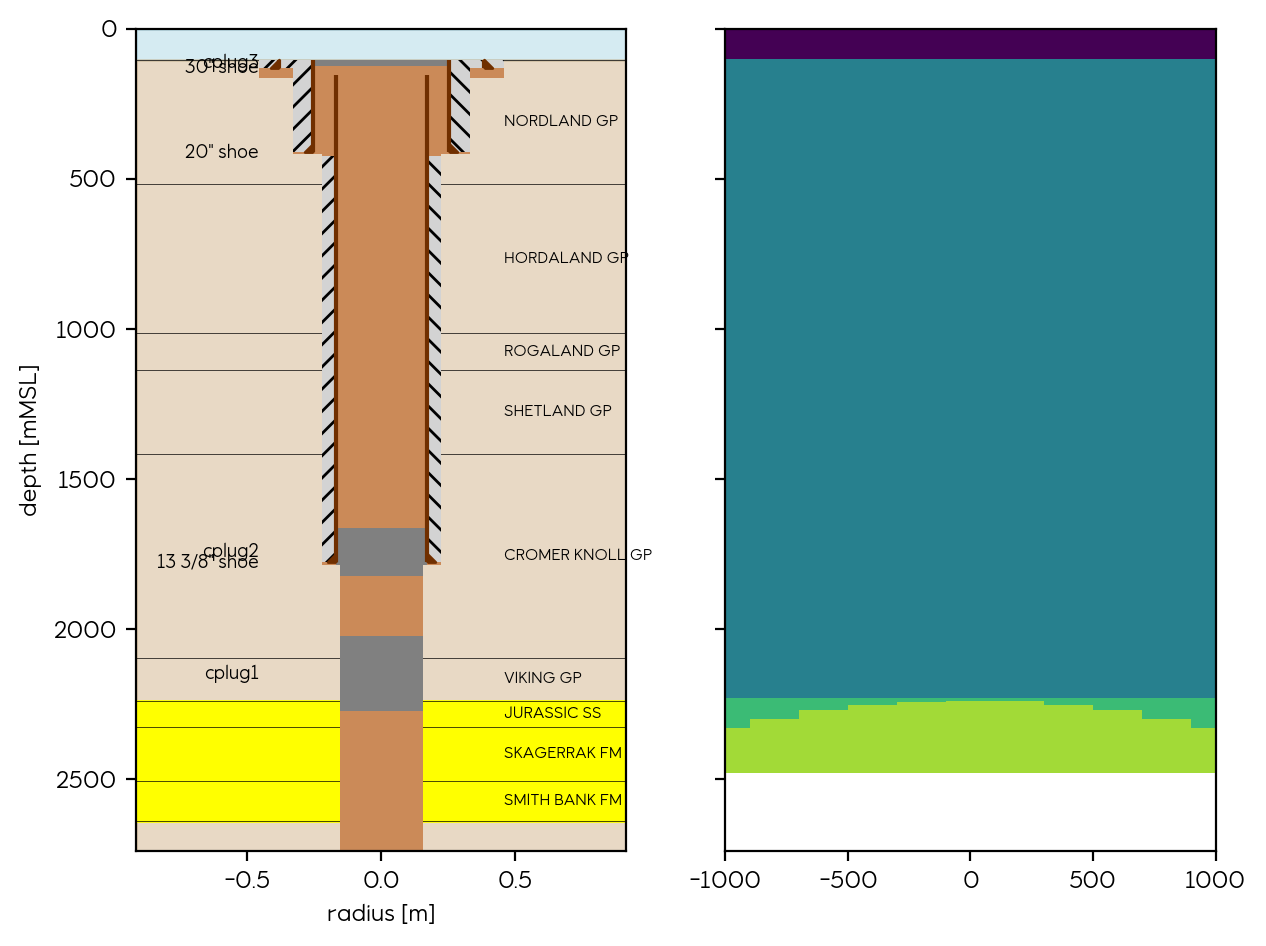

In [25]:
# coarse grid
grid_coarse = lgr.grid_coarse

plot_grid(my_well, grid_coarse, prop='FIPLEG')


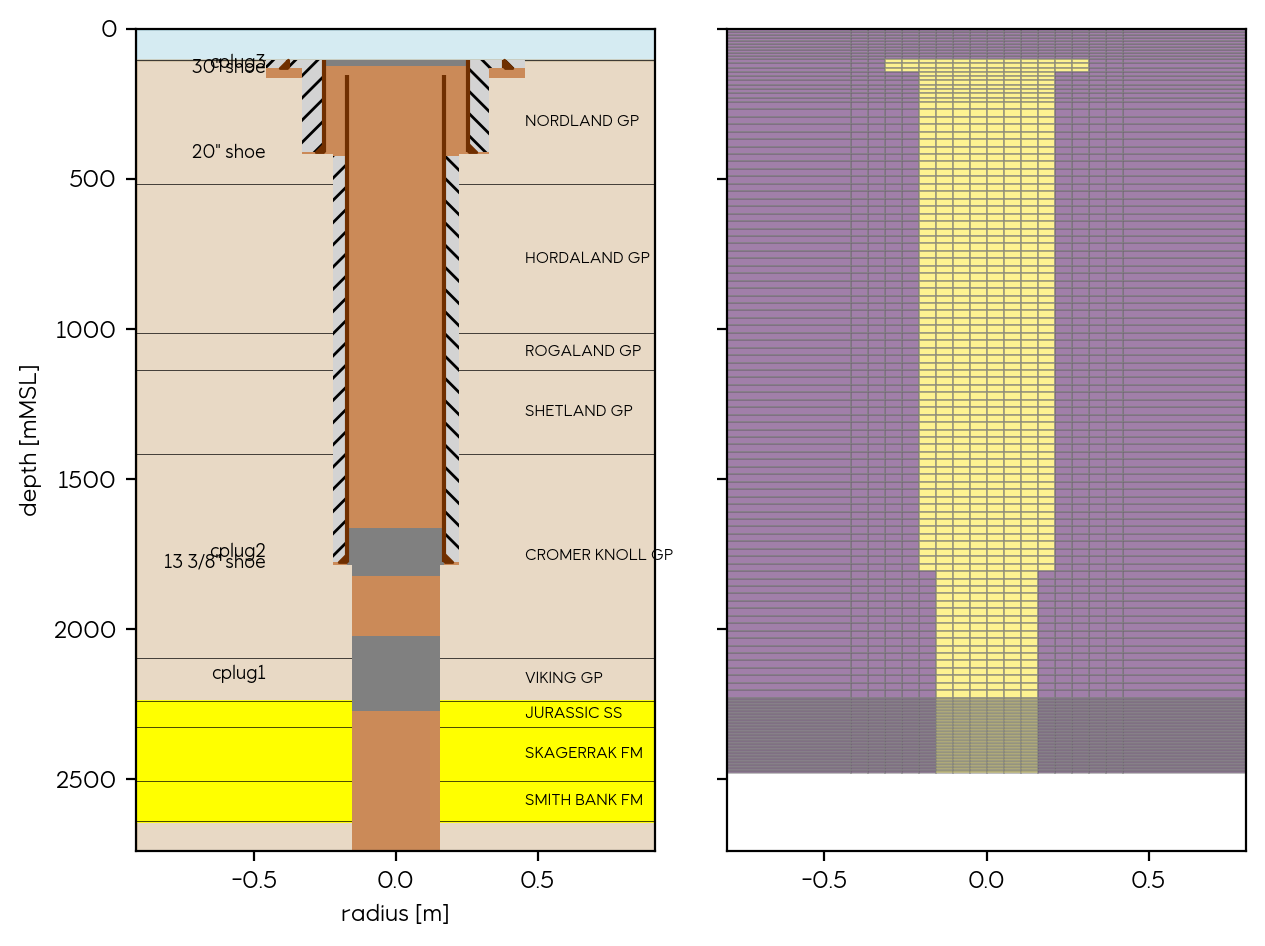

In [27]:
# LGR grid from pflotran output
PROPS = 'TRANZ'
PROPS = 'PERMX'
PROPS = 'FIPLEG'
# plot it
plot_grid(my_well, grid_lgr, prop=PROPS)

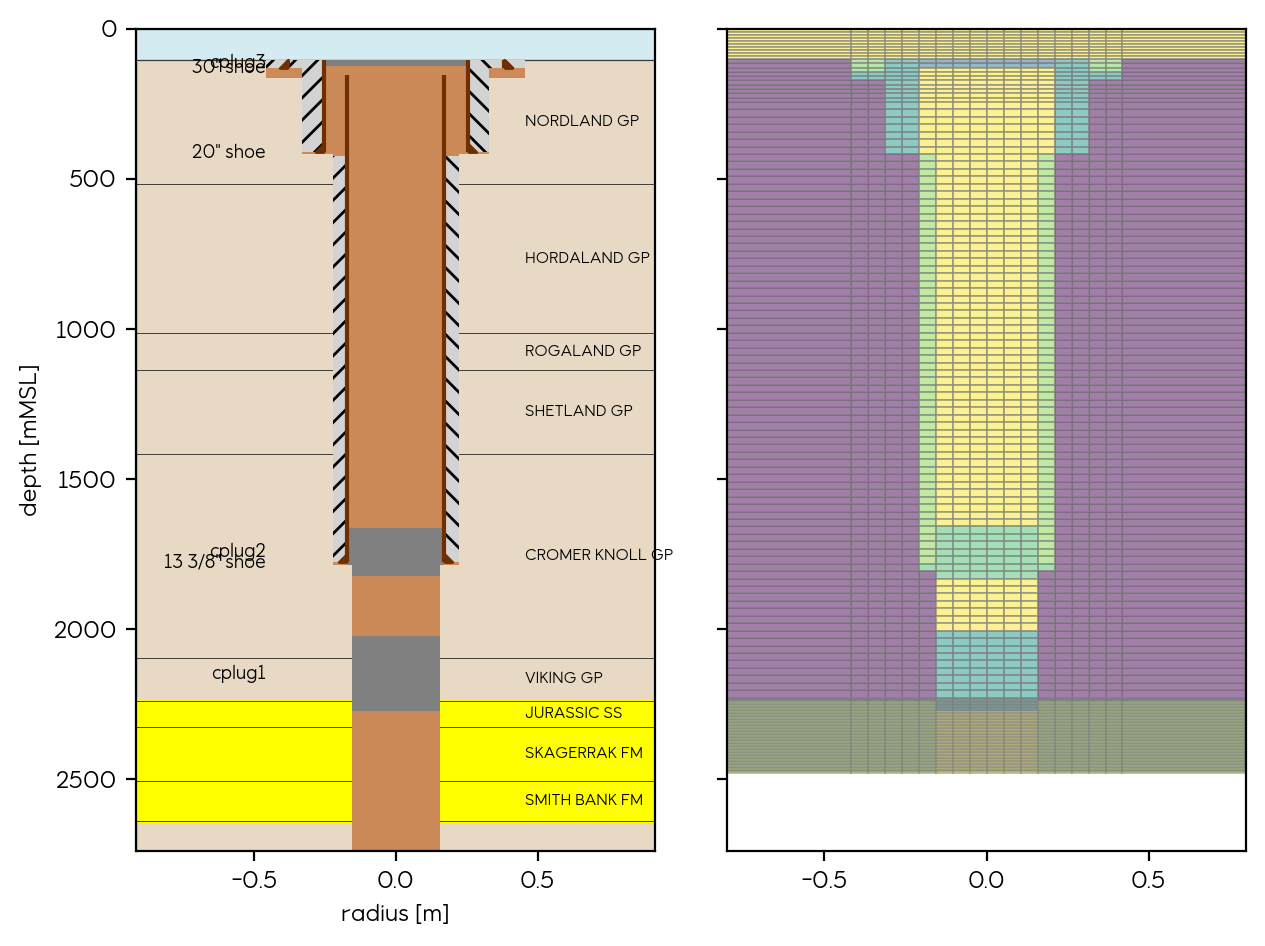

In [32]:
# LGR grid from dataframe
grid_refine = lgr.grid_refine

plot_grid(my_well, grid_refine)

# Other Qcs

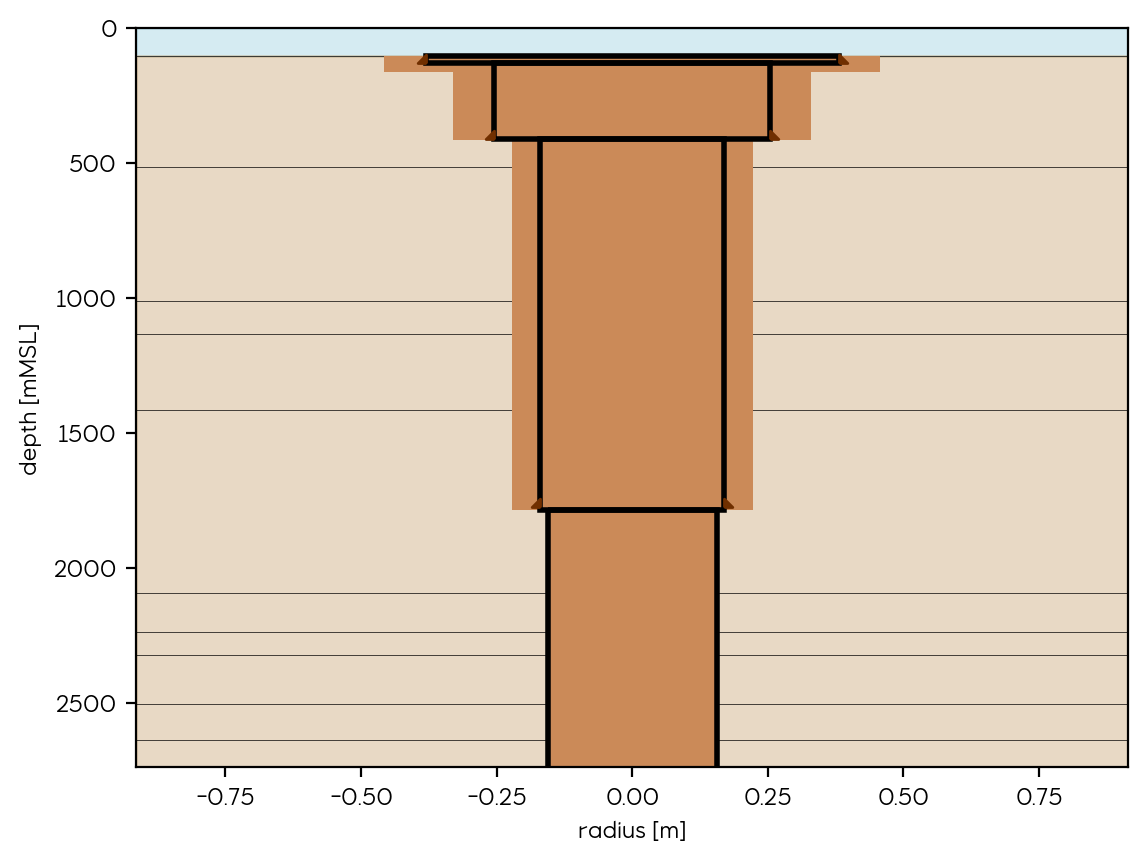

In [28]:
# testing plot_sketch
DEBUGGING = True
if DEBUGGING:
    from src.WellClass.libs.plotting import plot_sketch
    plot_sketch(my_well, 
                draw_annotation=False,
                draw_open_hole=True,
                draw_cement_bond=False,
                draw_casings=False, 
                draw_barriers=False)

In [29]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])

In [30]:
type(ip_grid)

pandas.core.frame.DataFrame

In [31]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

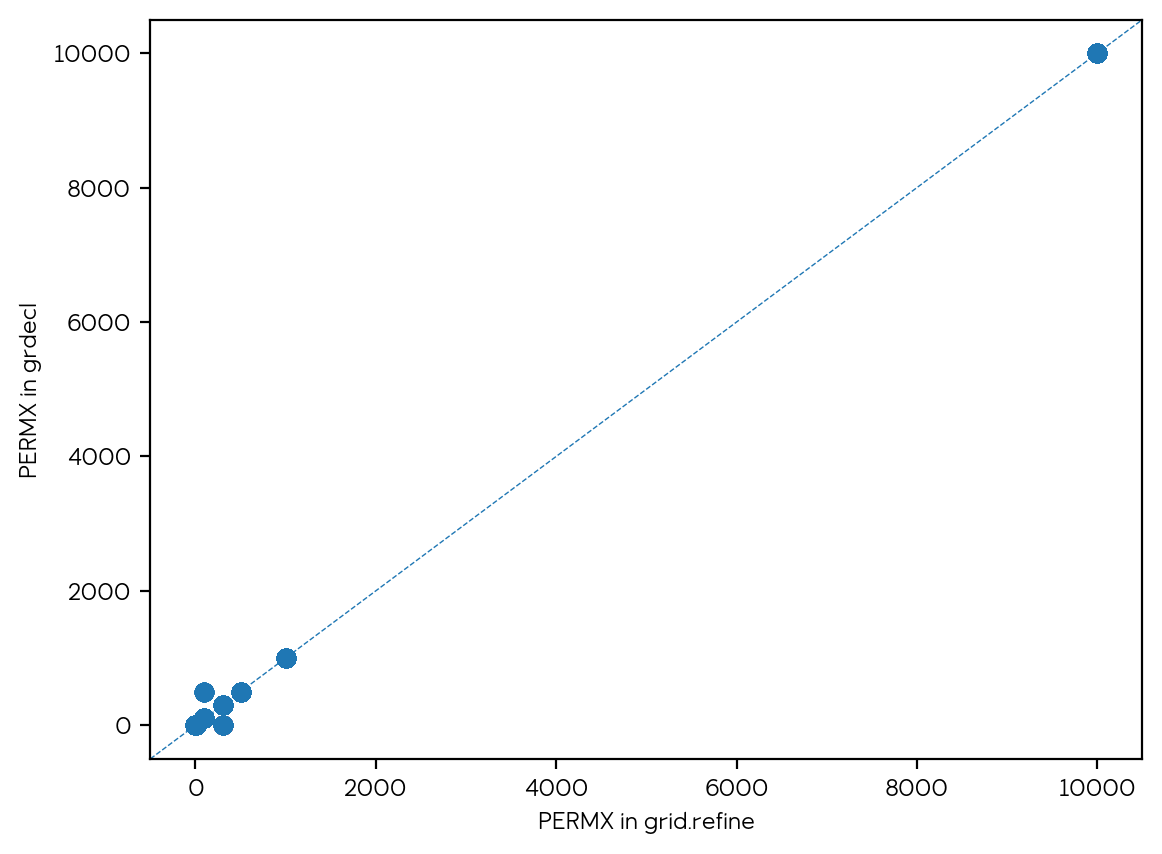

In [32]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

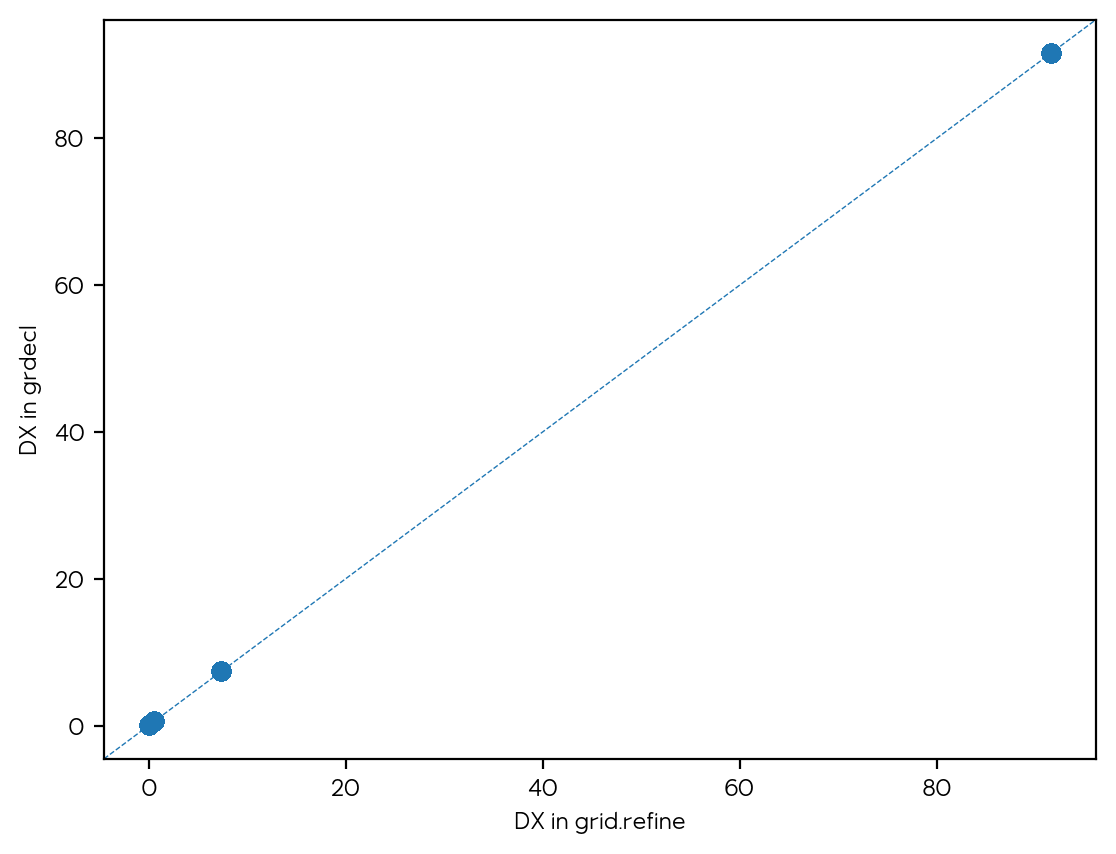

In [33]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

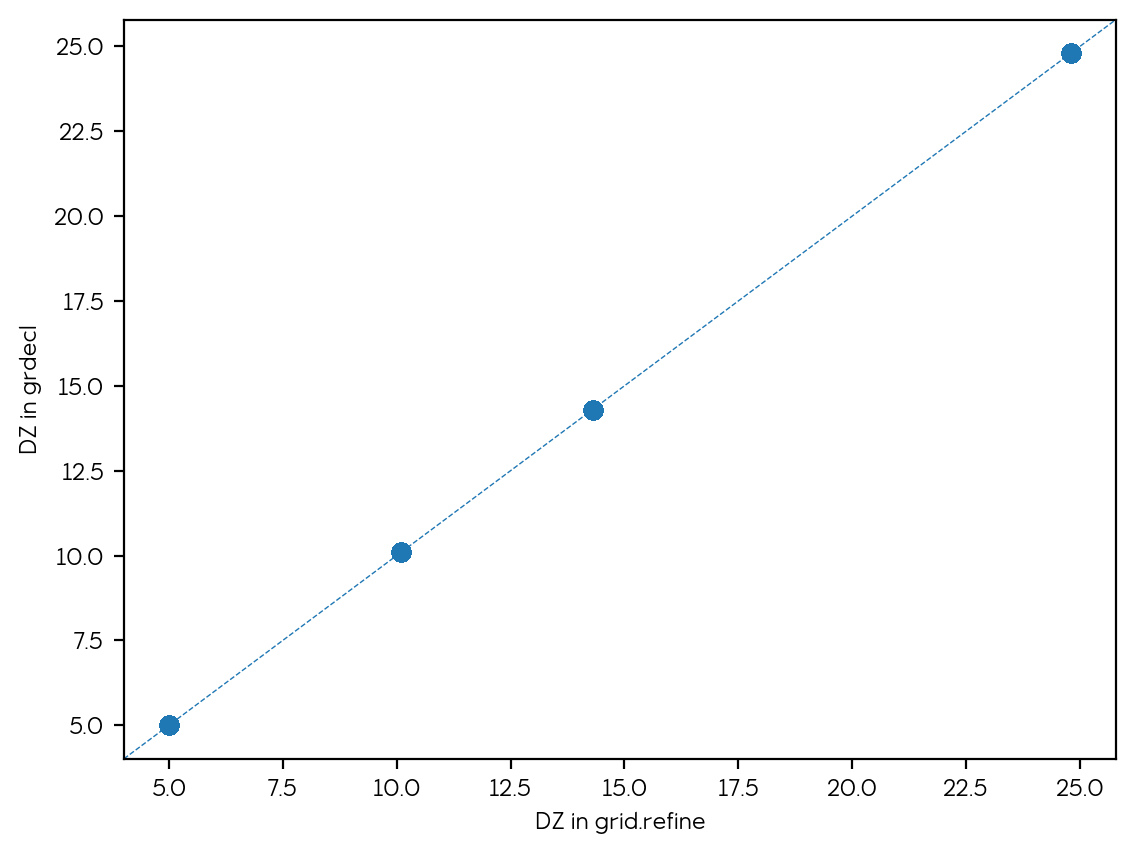

In [34]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')